# Interaction Mode Distance Evaluation

This notebook visualizes and analyzes the distributions of normalized and weighted feature distances for wallets across different interaction mode clustering results. The goal is to assess whether the distance score effectively reflects the proportionality and scale of a wallet's activity in a given interaction mode.

We will:
- Load the `normalised_distance.csv` and `weighted_distance.csv` files for each dataset.
- Visualize the distributions of feature distances.
- Compute and display key statistics (mean, median, std, skewness, kurtosis).
- Discuss the implications for using these distance scores as indicators of wallet activity.


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Define base path for results
data_base = '../data/raw_data/interaction_mode_results/'
clusters = ['main_clustering', 'cluster_0_clustering', 'cluster_1_clustering']

# File names
norm_file = 'normalised_distances.csv'
weight_file = 'weighted_distances.csv'

# Load all datasets into dictionaries
norm_dfs = {}
weight_dfs = {}
for cluster in clusters:
    norm_path = os.path.join(data_base, cluster, norm_file)
    weight_path = os.path.join(data_base, cluster, weight_file)
    if os.path.exists(norm_path):
        norm_dfs[cluster] = pd.read_csv(norm_path)
    if os.path.exists(weight_path):
        weight_dfs[cluster] = pd.read_csv(weight_path)


--- Weighted Distances: main_clustering ---


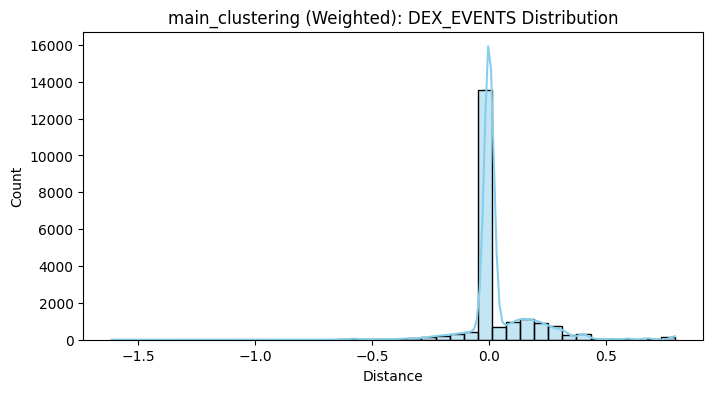

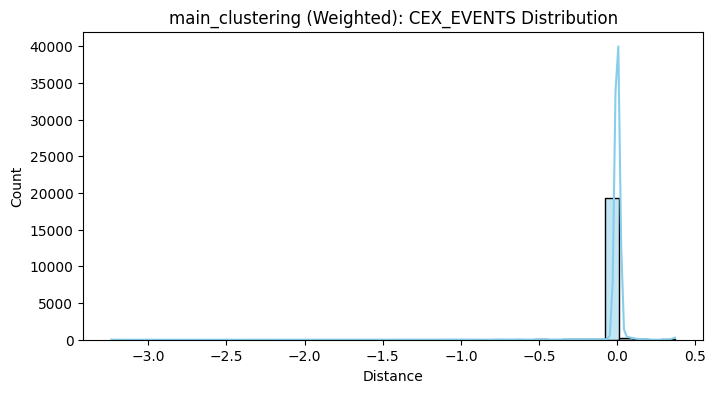

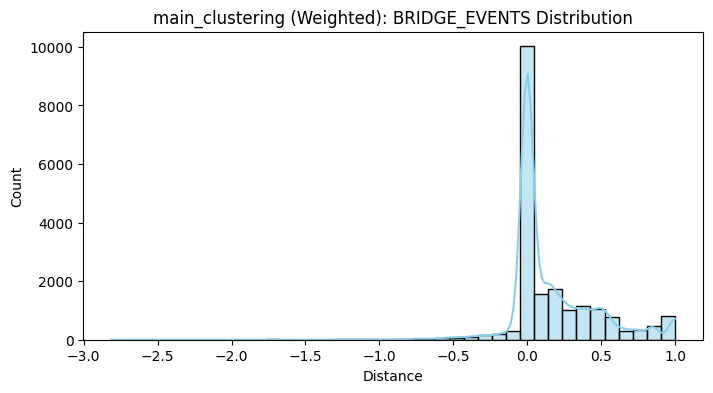

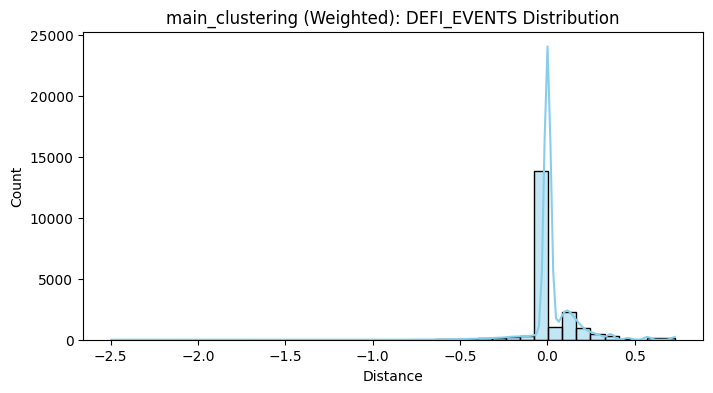

,mean,median,std,skewness,kurtosis
DEX_EVENTS,0.042376,0.0,0.145817,1.147391,11.011730
CEX_EVENTS,-0.007312,0.0,0.115151,-12.562749,223.970668
BRIDGE_EVENTS,0.168256,0.0,0.307520,0.552139,3.618635
DEFI_EVENTS,0.033782,0.0,0.133428,0.346241,17.352182


--- Weighted Distances: cluster_0_clustering ---


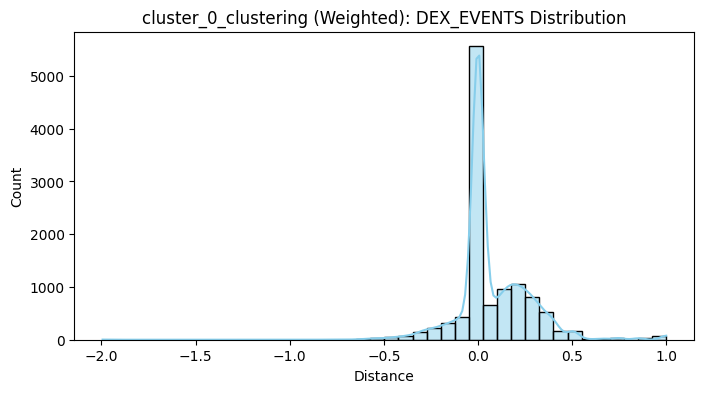

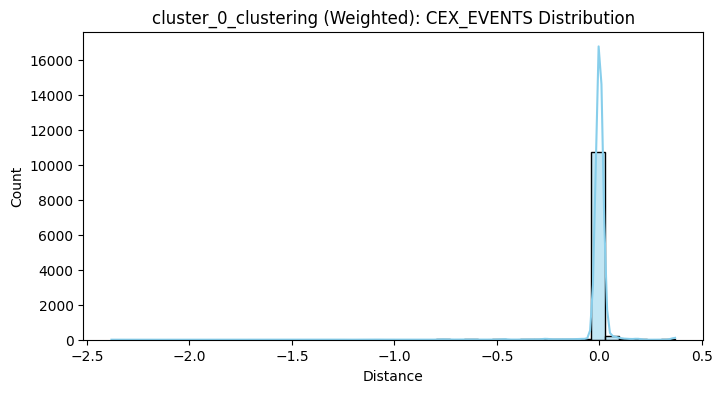

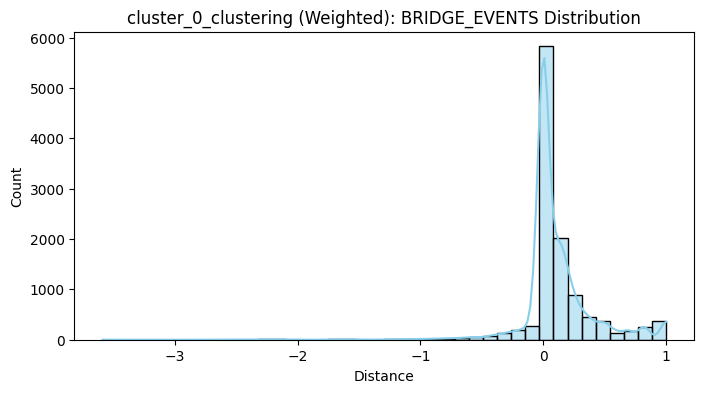

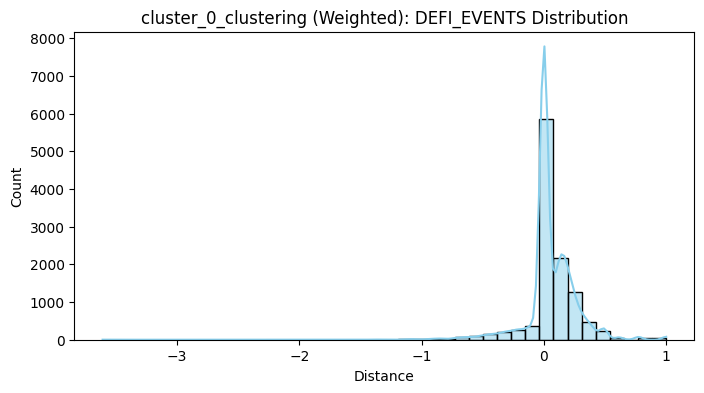

,mean,median,std,skewness,kurtosis
DEX_EVENTS,0.075131,0.0,0.195711,0.542791,7.870110
CEX_EVENTS,-0.008310,0.0,0.110633,-9.836939,133.193228
BRIDGE_EVENTS,0.114923,0.0,0.304261,-0.477207,12.524045
DEFI_EVENTS,0.055777,0.0,0.212770,-1.014650,14.775175


--- Weighted Distances: cluster_1_clustering ---


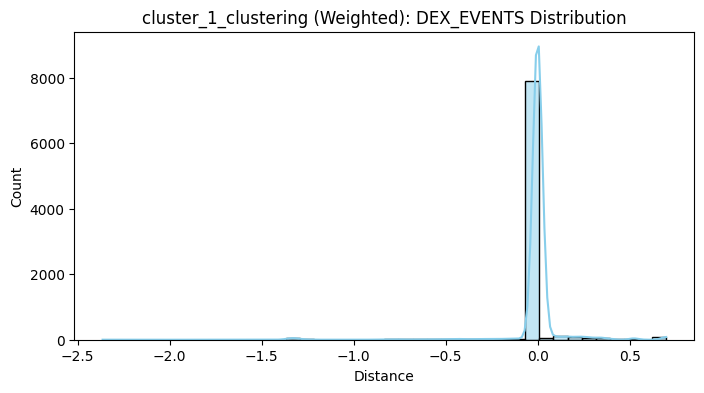

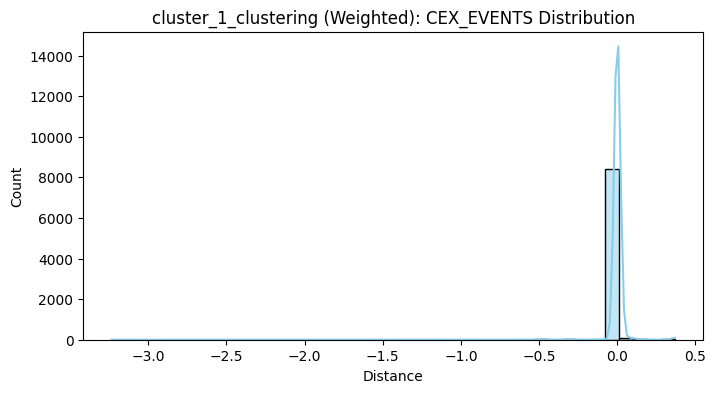

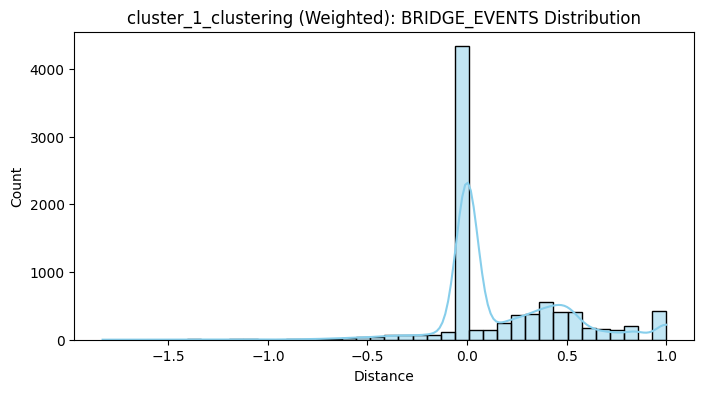

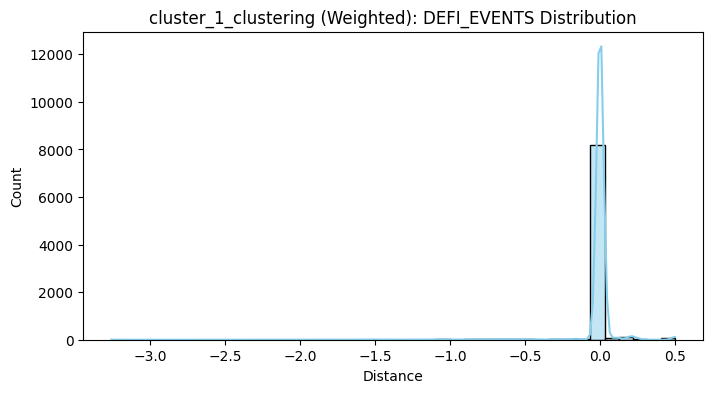

,mean,median,std,skewness,kurtosis
DEX_EVENTS,-0.001799,0.0,0.160227,-4.380804,45.580072
CEX_EVENTS,-0.005928,0.0,0.120710,-15.327443,307.769830
BRIDGE_EVENTS,0.186458,0.0,0.331608,0.476508,1.433375
DEFI_EVENTS,-0.007910,0.0,0.141676,-8.485121,119.399696


In [16]:
def plot_and_stats(df, title_prefix):
    stats = {}
    for col in df.columns:
        if not np.issubdtype(df[col].dtype, np.number):
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=40, color='skyblue')
        plt.title(f'{title_prefix}: {col} Distribution')
        plt.xlabel('Distance')
        plt.ylabel('Count')
        plt.show()
        # Compute statistics
        stats[col] = {
            'mean': np.mean(df[col]),
            'median': np.median(df[col]),
            'std': np.std(df[col]),
            'skewness': skew(df[col], nan_policy='omit'),
            'kurtosis': kurtosis(df[col], nan_policy='omit')
        }
    return pd.DataFrame(stats).T

# Visualize and summarize for each cluster and distance type
for cluster in clusters:
    if cluster in norm_dfs:
        print(f'--- Normalised Distances: {cluster} ---')
        display(plot_and_stats(norm_dfs[cluster], f'{cluster} (Normalised)'))
    if cluster in weight_dfs:
        print(f'--- Weighted Distances: {cluster} ---')
        display(plot_and_stats(weight_dfs[cluster], f'{cluster} (Weighted)'))


## Advanced Analytical Visualizations & Decision Support

To deepen our understanding and support key decision recommendations, we will:

- Visualize feature-wise distance distributions across clusters, highlighting the impact of shared medians.
- Compare feature medians within and across clusters to identify overlap and potential confounding effects.
- Use boxplots, violin plots, and pairwise feature scatterplots to reveal structure and outliers.
- Quantify the proportion of wallets with high distance scores (e.g., above 90th percentile) for each feature and cluster.
- Summarize which features and clusters are most discriminative for identifying significant wallets.

Special attention is given to the fact that some feature medians are derived from the same cluster, which may affect the interpretation of distance scores and the identification of outliers or high-activity wallets.

In [17]:
# Feature-wise boxplots and violin plots across clusters
import matplotlib.gridspec as gridspec

def plot_feature_distributions_across_clusters(norm_dfs, clusters, plot_type='box'):
    features = set()
    for df in norm_dfs.values():
        features.update([col for col in df.columns if np.issubdtype(df[col].dtype, np.number)])
    features = sorted(features)
    
    for feature in features:
        fig = plt.figure(figsize=(14, 6))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        
        data = []
        labels = []
        for cluster in clusters:
            if cluster in norm_dfs and feature in norm_dfs[cluster].columns:
                data.append(norm_dfs[cluster][feature].dropna())
                labels.append(cluster)
        
        if not data:
            continue
        
        if plot_type == 'box':
            ax1.boxplot(data, labels=labels, patch_artist=True)
            ax1.set_title(f'Boxplot: {feature} by Cluster')
        else:
            sns.violinplot(data=data, ax=ax1)
            ax1.set_xticklabels(labels)
            ax1.set_title(f'Violin Plot: {feature} by Cluster')
        ax1.set_ylabel('Normalised Distance')
        
        # Overlay medians for each cluster
        medians = [np.median(d) for d in data]
        ax2.barh(labels, medians, color='orange')
        ax2.set_title('Cluster Medians')
        ax2.set_xlabel('Median Distance')
        
        plt.suptitle(f'Feature: {feature} (Shared Medians May Affect Outlier Detection)')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_feature_distributions_across_clusters(norm_dfs, clusters, plot_type='box')
plot_feature_distributions_across_clusters(norm_dfs, clusters, plot_type='violin')

In [18]:
# Pairwise feature scatterplots within each cluster to visualize relationships and outliers
from itertools import combinations

def plot_pairwise_scatterplots(norm_dfs, clusters):
    for cluster in clusters:
        if cluster not in norm_dfs:
            continue
        df = norm_dfs[cluster].select_dtypes(include=[np.number])
        features = df.columns
        if len(features) < 2:
            continue
        print(f'Pairwise Feature Scatterplots for {cluster}')
        combs = list(combinations(features, 2))
        n = min(6, len(combs))  # Show up to 6 pairs for brevity
        fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
        if n == 1: axes = [axes]
        for i, (f1, f2) in enumerate(combs[:n]):
            ax = axes[i]
            ax.scatter(df[f1], df[f2], alpha=0.5, s=10)
            ax.set_xlabel(f1)
            ax.set_ylabel(f2)
            ax.set_title(f'{f1} vs {f2}')
        plt.suptitle(f'Pairwise Feature Distances in {cluster}\n(Shared medians may create artificial structure)')
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

plot_pairwise_scatterplots(norm_dfs, clusters)

In [19]:
# Proportion of wallets above 90th percentile for each feature and cluster
def high_distance_proportion(norm_dfs, clusters, percentile=0.9):
    summary = []
    for cluster in clusters:
        if cluster not in norm_dfs: continue
        df = norm_dfs[cluster].select_dtypes(include=[np.number])
        for feature in df.columns:
            threshold = df[feature].quantile(percentile)
            prop = (df[feature] > threshold).mean()
            summary.append({'cluster': cluster, 'feature': feature, 'threshold': threshold, 'proportion_above': prop})
    return pd.DataFrame(summary)

high_dist_df = high_distance_proportion(norm_dfs, clusters, percentile=0.9)

plt.figure(figsize=(12, 6))
sns.barplot(data=high_dist_df, x='feature', y='proportion_above', hue='cluster')
plt.title('Proportion of Wallets Above 90th Percentile Distance (per Feature/Cluster)')
plt.ylabel('Proportion > 90th Percentile')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

display(high_dist_df.sort_values(['proportion_above'], ascending=False).head(10))

ValueError: Could not interpret value `feature` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Summarize and rank features/clusters by discriminative power (variance, outlier proportion)
def feature_discriminative_summary(norm_dfs, clusters):
    summary = []
    for cluster in clusters:
        if cluster not in norm_dfs: continue
        df = norm_dfs[cluster].select_dtypes(include=[np.number])
        for feature in df.columns:
            var = df[feature].var()
            outlier_prop = (df[feature] > df[feature].quantile(0.9)).mean()
            summary.append({'cluster': cluster, 'feature': feature, 'variance': var, 'outlier_prop': outlier_prop})
    return pd.DataFrame(summary)

disc_df = feature_discriminative_summary(norm_dfs, clusters)

# Top discriminative features/clusters
top_disc = disc_df.sort_values(['variance', 'outlier_prop'], ascending=False).head(10)
display(top_disc)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=disc_df, x='variance', y='outlier_prop', hue='cluster', style='feature')
plt.title('Feature Discriminative Power: Variance vs Outlier Proportion')
plt.xlabel('Variance of Distance')
plt.ylabel('Proportion > 90th Percentile')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Recommendation:
print('Features and clusters in the top right are most useful for identifying significant wallets. Consider these for thresholding or further analysis. Shared medians may reduce discriminative power for some features.')

## Interpretation & Decision Recommendations

- **Boxplots/Violin Plots:** Compare feature distance distributions across clusters. Wide or skewed distributions may indicate features with strong outliers or high-activity wallets. Shared medians can cause artificial similarity between clusters—interpret with caution.
- **Pairwise Scatterplots:** Reveal relationships and potential collinearity between features. Clusters with tight or separated scatter patterns may be more robust for decision-making.
- **Proportion Above 90th Percentile:** Features/clusters with a high proportion of outliers are strong candidates for threshold-based wallet selection.
- **Discriminative Power (Variance vs Outlier Proportion):** Features/clusters in the top right of the scatterplot are most useful for identifying significant wallets. Shared medians may reduce the ability to distinguish outliers—consider this when setting thresholds or making recommendations.

**Recommendation:**
- Focus on features and clusters with high variance and high outlier proportion for identifying significant wallets.
- Where medians are shared across clusters, supplement distance scores with additional context or features to avoid misclassification.
- Use these insights to set data-driven thresholds or to prioritize features for further analysis.

## Interpretation and Next Steps

- Review the distribution plots for each feature and cluster to assess the spread and shape of the distance scores.
- Use the summary statistics (mean, median, std, skewness, kurtosis) to compare features and clusters.
- Consider:
    - Are the distributions heavy-tailed or symmetric?
    - Do high distance scores correspond to wallets with outlier or high-activity behavior?
    - Are the weighted distances more interpretable or discriminative than the normalised ones?
- Use these insights to refine the distance metric or to select thresholds for identifying significant wallets in each interaction mode.
